In [60]:
import pandas as pd
import numpy as np
import os
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [61]:
"""
Класс логистической регрессии был модифицирован и теперь метод fit возвращает список со значениями
функции ошибки (binary cross-entropy) на каждой итерации обучения.

Вы можете сравнивать графики функции ошибки для модели, обученной на `сырых данных` (пункт 1.1), и для модели,
обученной на трансформированных данных (данные из пункта 1.3), для анализа влияния трансформаций на динамику обучения модели
(ускорение обучения, ошибка ниже на первой итерации и т.д.).
"""

def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy(pred, label):
    return -np.mean(label * np.log(pred + 1e-6) + (1. - label) * np.log(1 - pred + 1e-6))


class LogisticRegression:
    def __init__(self, dim=2):
        rng = np.random.default_rng(seed=0)
        self.w = rng.normal(size=(dim, 1)) / np.sqrt(dim)
        self.b = np.zeros((1,))

    def predict(self, x, probs=False):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        x = x.dot(self.w) + self.b
        p = sigmoid(x)
        if probs:
            return p
        return np.array(p > 0.5).astype('int32')

    def fit(self, x, y, iters=300, lr=0.1):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        # y - np.array размернсоти [N]
        #     Массив меток (правильных ответов).
        assert len(x) == len(y), \
            "Количество экземпляров в массиве X не равно количеству меток в массиве Y. " + \
            f"Полученные размеры: len(X) = {len(x)}, len(Y) = {len(y)}."
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        y = y.reshape(-1, 1)
        loss = []
        for i in range(iters):
            preds = self.predict(x, probs=True)
            self.w -= lr * x.T.dot(preds - y) / y.shape[0]
            self.b -= lr * np.mean(preds - y, axis=0)
            loss.append(binary_cross_entropy(preds, y))
        return loss

In [62]:
def load_data(folder_path):
    x_train = pd.read_csv(os.path.join(folder_path, 'x_train.csv'))
    y_train = pd.read_csv(os.path.join(folder_path, 'y_train.csv'))
    x_test = pd.read_csv(os.path.join(folder_path, 'x_test.csv'))
    y_test = pd.read_csv(os.path.join(folder_path, 'y_test.csv'))
    return x_train, y_train, x_test, y_test

In [63]:
from google.colab import drive
drive.mount('/content/drive')
x_train, y_train, x_test, y_test = load_data('/content/drive/MyDrive/lr3_dataset/')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [64]:
x_train.head()

,statuses_count,followers_count,friends_count,favourites_count,listed_count,is_default_profile,is_profile_use_background_image,user_age,tweets_freq,followers_growth_rate,friends_growth_rate,favourites_growth_rate,listed_growth_rate,followers_friends_ratio,screen_name_length,num_digits_in_screen_name,length_of_name,num_digits_in_name,description_length
0,38278,19692,3289,40071,335,0,1,4278,8.947639,4.603086,0.768817,9.366760,0.078308,5.987230,10,0,11,0,136
1,97523,54632,3544,1563,1091,0,0,4583,21.279293,11.920576,0.773293,0.341043,0.238054,15.415350,13,2,13,2,156
2,13533,2835,1246,1217,95,0,1,4629,2.923526,0.612443,0.269173,0.262908,0.020523,2.275281,7,2,11,0,119
3,13159,13950,2009,9477,161,0,0,4256,3.091870,3.277726,0.472039,2.226739,0.037829,6.943753,14,0,14,0,108
4,34670,19234,544,6587,121,1,1,3280,10.570122,5.864024,0.165854,2.008232,0.036890,35.356618,6,0,16,0,159


В данной лабораторной работе будет практиковаться обработка данных на примере датасета для задачи распознавания ботов в социальной сети Твиттер. Класс 0 означает человек, класс 1 означает бот. `Обучите модель так, чтобы вероятность пропуска бота составляла менее 4% (данный порог может быть ослаблен в зависимости от общих результатов лабораторных). Значение метрики F1 должно быть не менее 0.95.`

Требование: использовать лишь 10 признаков (это могут быть либо сгенерированные признаки, либо отобранные).

Допускается коллаборация (использование подходов к обработке данных, придуманных другими студентами) при условии ссылки на автора подхода в комментариях к коду (фамилия и инициалы).

## 1.1 Обучение baseline модели

Указание: `в данном пункте не применяйте трансформации к данным за рамками указанных`. Это необходимо для того, чтобы вы могли проводить сравнение в дальнейшем для лучшего понимания влияния вашего подхода к обработке данных на качество модели. Обучение baseline модели - стандартная практика, что даёт вам минимально рабочую модель и при этом позволяет отслеживать ваш прогресс.

In [65]:
# Снизьте размерность данных одним из способов:
# 1. вручную отобрав 10 признаков
# 2. используя PCA (from sklearn.decomposition import PCA)
# Указание: не нормализуйте данные (min/max, mean/std и прочее).

pca = PCA(n_components=10)
x_train_pca = pca.fit_transform(x_train)
x_test_pca = pca.transform(x_test)

In [66]:
# Обучите модель логистической регрессии на данных из клетки выше.

baseline_model = LogisticRegression(dim=10)
loss_baseline = baseline_model.fit(x_train_pca, y_train.values.flatten(), iters=300, lr=0.1)

<ipython-input-61-0f459a7b03a0>:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


<ipython-input-61-0f459a7b03a0>:11: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


Accuracy: 0.7396
F1 score: 0.2775
Матрица ошибок:
[[331  41]
 [ 84  24]]


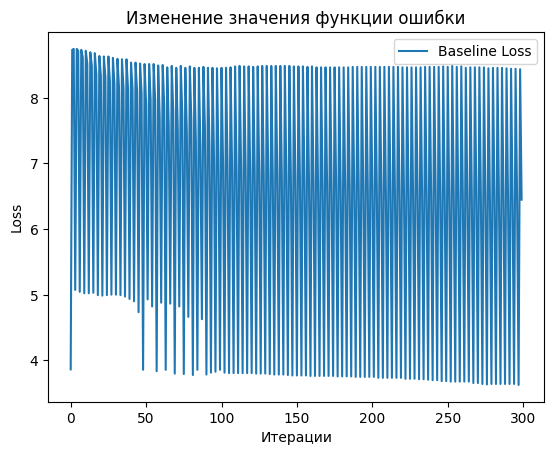

In [67]:
# Оцените качество обученной модели (точность, матрица ошибок), взгляните на динамику изменения функции ошибки в ходе обучения.

y_pred_baseline = baseline_model.predict(x_test_pca)

accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
f1_baseline = f1_score(y_test, y_pred_baseline)
conf_matrix_baseline = confusion_matrix(y_test, y_pred_baseline)

print(f"Accuracy: {accuracy_baseline:.4f}")
print(f"F1 score: {f1_baseline:.4f}")
print(f"Матрица ошибок:\n{conf_matrix_baseline}")

plt.plot(loss_baseline, label="Baseline Loss")
plt.title("Изменение значения функции ошибки")
plt.xlabel("Итерации")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 1.2 Анализ данных

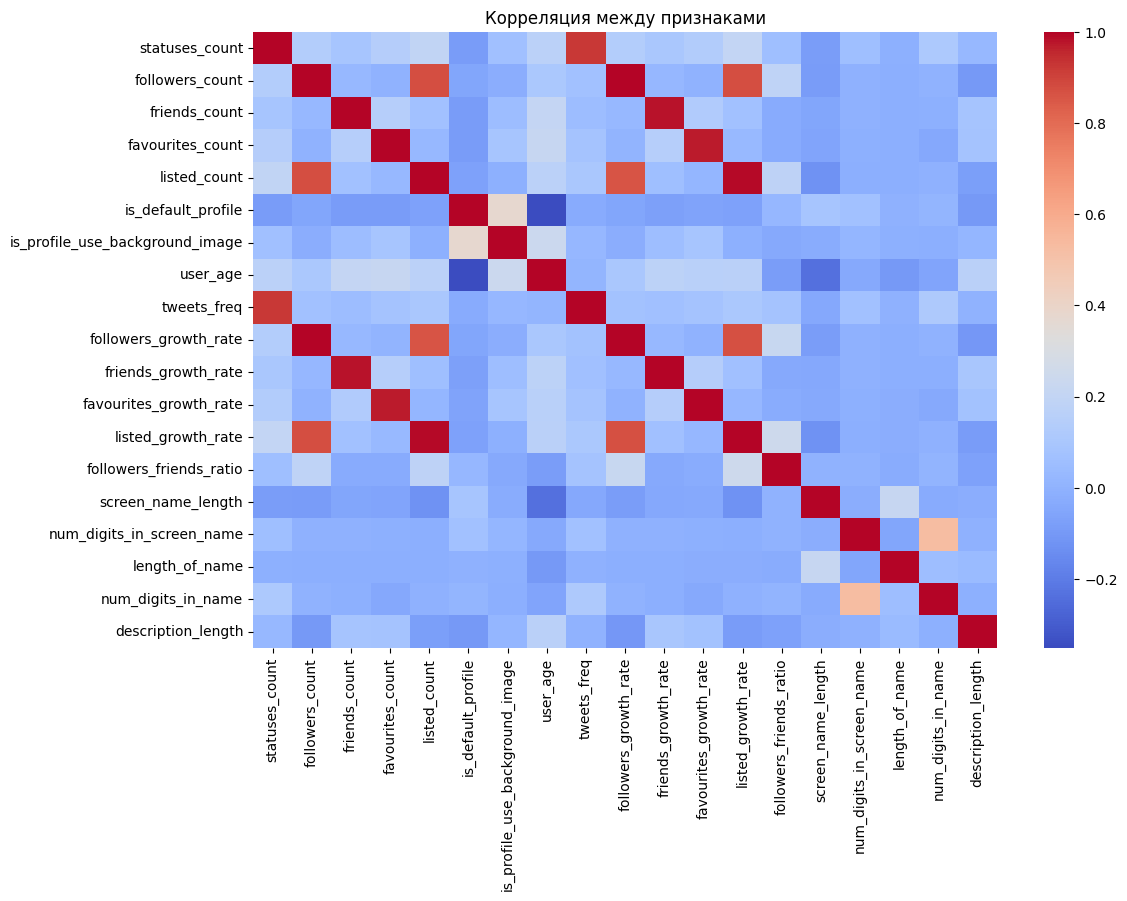

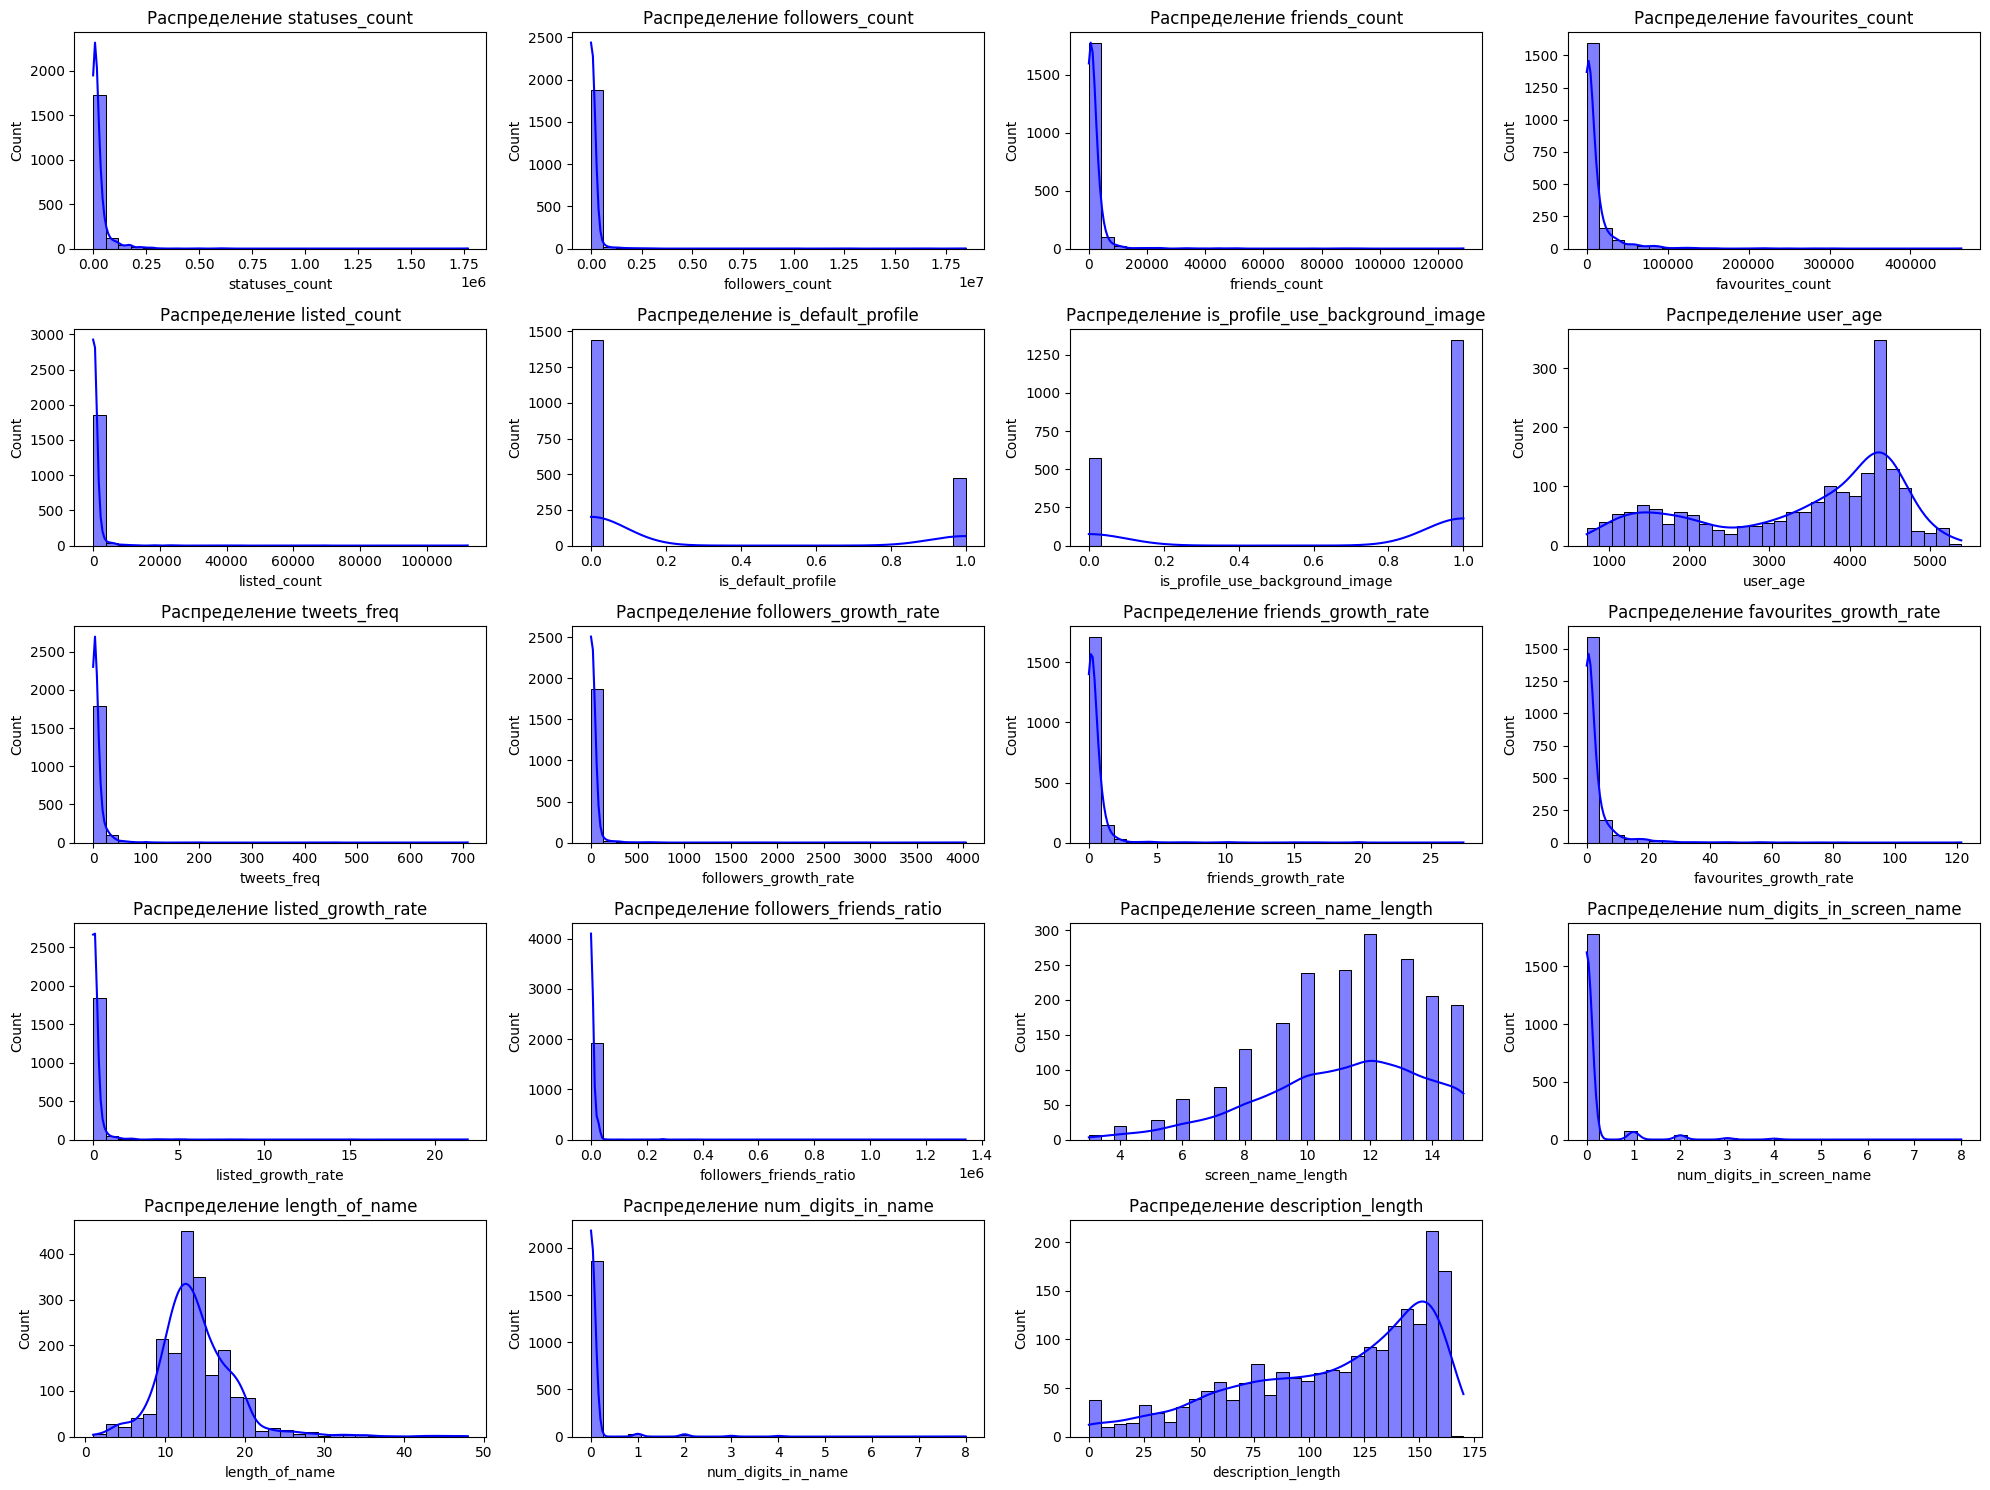

In [68]:
# Проведите анализ данных (наличие выбросов, визуализация распределения отдельных признаков и т.д.).

plt.figure(figsize=(12, 8))
sns.heatmap(x_train.corr(), annot=False, cmap='coolwarm')
plt.title("Корреляция между признаками")
plt.show()

plt.figure(figsize=(20, 15))
for i, col in enumerate(x_train.columns, 1):
    plt.subplot(5, 4, i)
    sns.histplot(x_train[col], kde=True, bins=30, color='blue')
    plt.title(f"Распределение {col}")
plt.tight_layout()
plt.show()

In [ ]:
# 1. Опишите в данной клетке ваши наблюдения.
# 2. Предложите идеи к обработке/улучшению качества данных.

#Как можно заметить, многие признаки имеют "длинный хвост", что указывает на наличие выбросов.
#Выбросы присутствуют в таких признаках, как statuses_count, followers_count, friends_count и др., а такие бинарные признаки, как
#is_default_profile, не имеют выбросов, так как их значения фиксированы.
#Следовательно, нужна обработка выбросов. Можно использовать такие методы отсечения, как перцентильный анализ, логарифмическое преобразование.
#Также можно заметить, что разные признаки имеют разный размах значений, для чего можно использовать масштабирование.
#Также видно, что есть признаки, которые сильно коррелированны между собой,
#следовательно, надо исключить признаки с высокой корреляцией, т.к. они добавляют избыточность, для этого можно использовать PCA,
#но это итак планировалось использовать.

## 1.3 Обработка данных

In [69]:
# Реализуйте идеи по нормировке/улучшению качества данных.

x_train_processed = x_train.copy()
x_test_processed = x_test.copy()

#Применяем перцентильный анализ
for col in x_train_processed.columns:
    low, high = np.percentile(x_train_processed[col], [1, 99])
    x_train_processed[col] = np.clip(x_train_processed[col], low, high)
    x_test_processed[col] = np.clip(x_test_processed[col], low, high)

#Применяем логарифмическое преобразование
cols_to_log = ['statuses_count', 'followers_count', 'friends_count',
               'favourites_count', 'listed_count', 'tweets_freq',
               'followers_growth_rate', 'friends_growth_rate',
               'favourites_growth_rate', 'listed_growth_rate']

for col in cols_to_log:
    x_train_processed[col] = np.log1p(x_train_processed[col])  #log1p = log(1 + x)
    x_test_processed[col] = np.log1p(x_test_processed[col])

#Применяем масштабирование
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train_processed)
x_test_scaled = scaler.transform(x_test_processed)

pca = PCA(n_components=10)
x_train_pca2 = pca.fit_transform(x_train_scaled)
x_test_pca2 = pca.transform(x_test_scaled)

## 1.4 Обучение итоговой модели

In [70]:
# Обучите модель на трансформированных данных.

final_model = LogisticRegression(dim=10)
final_loss = final_model.fit(x_train_pca2, y_train.values.flatten(), iters=300, lr=0.1)

Accuracy: 0.9833
F1 score: 0.9626
Матрица ошибок:
 [[369   3]
 [  5 103]]


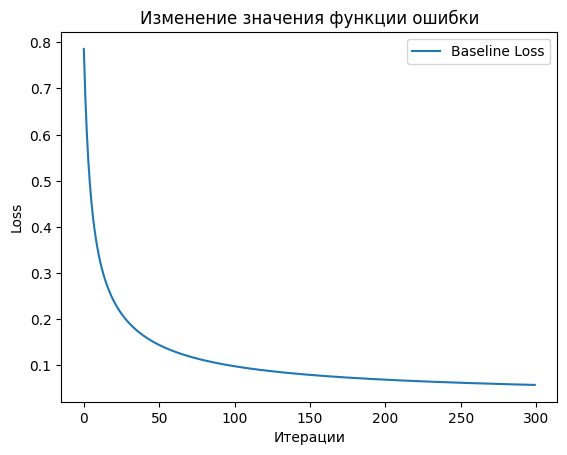

In [71]:
# Оцените качество обученной модели (точность, матрица ошибок).
# Взгляните (matplotlib) на динамику изменения функции ошибки в ходе обучения.

y_pred_final = final_model.predict(x_test_pca2)

accuracy_final = accuracy_score(y_test, y_pred_final)
f1_final = f1_score(y_test, y_pred_final)
cm_final = confusion_matrix(y_test, y_pred_final)

print(f"Accuracy: {accuracy_final:.4f}")
print(f"F1 score: {f1_final:.4f}")
print("Матрица ошибок:\n", cm_final)

plt.plot(final_loss, label='Baseline Loss')
plt.title("Изменение значения функции ошибки")
plt.xlabel('Итерации')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# Сравните результат с моделью из пункта 1.1.

#В первом случае точность не такая высокая, а F1 score очень низкий, что указывает на проблемы с классификацией.
#Во втором случае модель значительно лучше: точность и F1 score гораздо выше, что говорит о более успешном распознавании классов,
#что видно и по матрице ошибок, количество ложных срабатываний для обоих классов в итоге
#минимально (3 ложных для класса 0 и 5 ложных для класса 1).
#В первом случае ошибки гораздо более выражены, особенно для ботов (класс 1), где много ложных отрицательных (84).
#Также график значения функции ошибки в изначальном варианте говорит о нестабильности модели.
#А в итоге график функции ошибки стабилен и монотонно убывает, что говорит о стабильности и о том, что в целом всё идет хорошо.

## 2. Доп. задание (опционально)

В некоторых случаях вместо балансировки классов на уровне данных (как в ЛР1) используется балансировка на алгоритмическом уровне:
взвешиваются значения функции ошибки для разных классов (большие веса используются для редких классов, малые веса для доминирующих классов), чтобы модель во время обучения 'фокусировалась' на редких классах. В данной лабораторной работе балансировка на уровне данных возможна, однако рассмотрение алгоритмического подхода даст вам еще один полезный практический инструмент.

Модифицируйте класс логистической регрессии так, чтобы во время обучения значения функции ошибки взвешивались для разных классов.
Изменения будут представлять собой взвешивание индивидуальных градиентов (строки кода 28 и 29) для отдельных экземпляров данных.

Указание: не изменяйте код, связанный с вычислением `binary_cross_entropy`.

Сложность: энтузиаст-математик.

In [56]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def binary_cross_entropy(pred, label):
    return -np.mean(label * np.log(pred + 1e-6) + (1. - label) * np.log(1 - pred + 1e-6))


class LogisticRegression:
    def __init__(self, dim=2, class_weight=None):
        rng = np.random.default_rng(seed=0)
        self.w = rng.normal(size=(dim, 1)) / np.sqrt(dim)
        self.b = np.zeros((1,))
        self.class_weight = class_weight

    def predict(self, x, probs=False):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"
        x = x.dot(self.w) + self.b
        p = sigmoid(x)
        if probs:
            return p
        return np.array(p > 0.5).astype('int32')

    def fit(self, x, y, iters=300, lr=0.1):
        # x - np.array размерности [N, dim]
        #     Массив входных признаков.
        # y - np.array размернсоти [N]
        #     Массив меток (правильных ответов).
        assert len(x) == len(y), \
            "Количество экземпляров в массиве X не равно количеству меток в массиве Y. " + \
            f"Полученные размеры: len(X) = {len(x)}, len(Y) = {len(y)}."
        assert x.shape[1] == self.w.shape[0], \
            "Размерность экземпляров данных не соответствует ожидаемой: " + \
            f"ожидалось x.shape[1]={self.w.shape[0]}, но было получено x.shape[1]={x.shape[1]}"

        # ВНЕСИТЕ МОДИФИКАЦИИ ЗДЕСЬ.
        # ----------------------------------------------------
        y = y.reshape(-1, 1)
        loss = []
        for i in range(iters):
            preds = self.predict(x, probs=True)
            self.w -= lr * x.T.dot(preds - y) / y.shape[0]
            self.b -= lr * np.mean(preds - y, axis=0)
            loss.append(binary_cross_entropy(preds, y))
        # ----------------------------------------------------
        return loss

### 2.1 Обучение без взвешивания

In [59]:
# Создайте и обучите новую модель на данных из пункта 1.4 без использования взвешивания (коэффициенты 1/1).
# Сохраните возвращенные значения функции ошибки, визуализируйте их.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).
# Убедитесь, что результаты схожи с результатами из пункта 1.4 (в идеале они должны быть равны).

# Напишите ваш код здесь.

### 2.2 Обучение с большим весом на классе 0

In [ ]:
# Создайте и обучите новую модель на данных из пункта 1.4 с большим весом на классе 0 (например 10|1)
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.

In [ ]:
# Визуализируйте значения функции ошибки из пункта 2.1 и из текущего пункта.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.

In [ ]:
# Сравните матрицу ошибок с матрицей из пункта 2.1.

# Напишите ваши выводы здесь.

### 2.3 Обучение с большим весом на классе 1

In [ ]:
# Создайте и обучите новую модель на данных из пункта 1.4 с большим весом на классе 0 (например 1|10)
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.

In [ ]:
# Визуализируйте значения функции ошибки из пунктов 2.1, 2.2 и из текущего пункта.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.

In [ ]:
# Сравните матрицу ошибок с матрицами из пунктов 2.1, 2.2.

# Напишите ваши выводы здесь.

### 2.4 Обучение с оптимальными весами

In [ ]:
# Создайте и обучите новую модель на данных из пункта 1.4.
# Найдите веса, что дают более высокую точность, нежели точность из пункта 1.4.
# Сохраните возвращенные значения функции ошибки.

# Напишите ваш код здесь.

In [ ]:
# Визуализируйте значения функции ошибки из пунктов 2.1, 2.2, 2.3 и из текущего пункта.

# Напишите ваш код здесь.

In [ ]:
# Оцените качество обученной модели (точность, матрица ошибок).

# Напишите ваш код здесь.

In [ ]:
# Сравните матрицу ошибок с матрицей из пункта 2.1.

# Напишите ваши выводы здесь.